# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div> 

- **Training** 
    - Train-Test Split
    - Cross Validation
- **Hypertuning**
     - Optuna
     - Trade-Off Bias/Variance
     - Save Model

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Training</p></div> 

In [270]:
# Machine Learning Models
from lightgbm import LGBMClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

import pickle
from datetime import datetime

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [237]:
%%capture
%run part03_preparation.ipynb

In [238]:
X.shape, y.shape

((87245, 14), (87245,))

In [257]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((69796, 14), (69796,), (17449, 14), (17449,))

In [258]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [259]:
def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC']) 
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    #print(f"AUC: {auc:.4f}\n\n")     
   
    return y_prob, auc

In [260]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

In [261]:
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED)

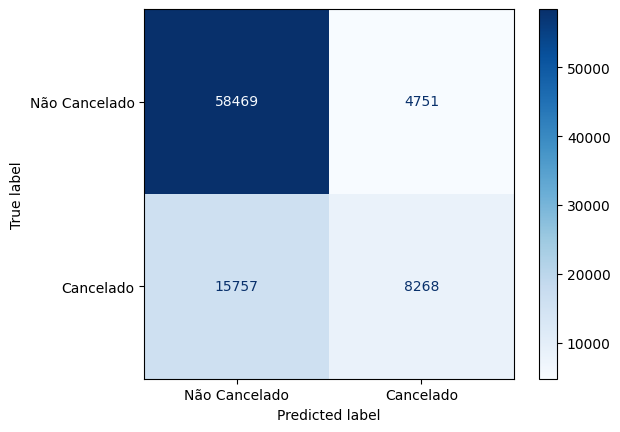

Score: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85     63220
           1       0.64      0.34      0.45     24025

    accuracy                           0.76     87245
   macro avg       0.71      0.63      0.65     87245
weighted avg       0.75      0.76      0.74     87245



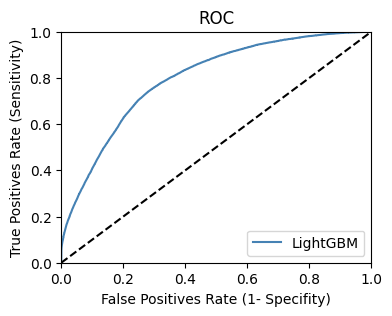

,value,std
fit_time,0.122206,0.008075
score_time,0.030423,0.003336
test_accuracy,0.764938,0.002708
train_accuracy,0.770984,0.000657
test_precision,0.635151,0.009942
train_precision,0.655019,0.003447
test_recall,0.344142,0.006468
train_recall,0.355765,0.006116
test_f1,0.446371,0.006769
train_f1,0.461047,0.004618


In [262]:
lgbm_y_prob, lgbm_y_pred  = CVS(lgbm_model,X,y,'LightGBM')

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

In [263]:
def objective(trial):
    
    weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),        
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        #'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
        'seed': RANDOM_SEED
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)#random_state=RANDOM_SEED
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return f1_score(y,y_pred)   

In [246]:
study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=100);

trial = study.best_trial

[I 2023-06-11 00:21:08,420] A new study created in memory with name: no-name-52dda5ec-ee5a-4897-afda-18514dbd7112
[I 2023-06-11 00:21:10,142] Trial 0 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 140, 'max_depth': 11, 'learning_rate': 0.0027521368932386485, 'reg_alpha': 9.806718140627652e-07, 'reg_lambda': 0.04621081588462532, 'subsample_freq': 8, 'min_child_samples': 8, 'scale_pos_weight': 2.631}. Best is trial 0 with value: 0.0.
[I 2023-06-11 00:21:11,476] Trial 1 finished with value: 0.09897004853794247 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 9, 'learning_rate': 0.0044522193133915075, 'reg_alpha': 0.5496224908798574, 'reg_lambda': 0.0033825683989750226, 'subsample_freq': 3, 'min_child_samples': 8, 'scale_pos_weight': 2.631}. Best is trial 1 with value: 0.09897004853794247.
[I 2023-06-11 00:21:12,424] Trial 2 finished with value: 0.0 and parameters: {'objective': 'binary

[I 2023-06-11 00:21:38,320] Trial 20 finished with value: 0.5977338532862475 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 180, 'max_depth': 14, 'learning_rate': 0.03779686752050245, 'reg_alpha': 2.4524090044804184e-05, 'reg_lambda': 0.14073482429797113, 'subsample_freq': 8, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 13 with value: 0.6018399479071009.
[I 2023-06-11 00:21:39,850] Trial 21 finished with value: 0.6001063193567678 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.05522009967647113, 'reg_alpha': 0.0012361653509761921, 'reg_lambda': 0.303043483565819, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 13 with value: 0.6018399479071009.
[I 2023-06-11 00:21:41,343] Trial 22 finished with value: 0.6007362617227192 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'lea

[I 2023-06-11 00:22:10,694] Trial 40 finished with value: 0.4591839450640121 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 13, 'learning_rate': 0.07910641524366135, 'reg_alpha': 6.286805337873409e-05, 'reg_lambda': 0.40368258748650593, 'subsample_freq': 9, 'min_child_samples': 7, 'scale_pos_weight': 1}. Best is trial 13 with value: 0.6018399479071009.
[I 2023-06-11 00:22:12,322] Trial 41 finished with value: 0.6008326394671107 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.06509056308460298, 'reg_alpha': 0.0002999829744727082, 'reg_lambda': 0.0879655149607107, 'subsample_freq': 4, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 13 with value: 0.6018399479071009.
[I 2023-06-11 00:22:14,011] Trial 42 finished with value: 0.6008423646140272 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 15, 'learning

[I 2023-06-11 00:22:43,221] Trial 60 finished with value: 0.5992391141827123 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 13, 'learning_rate': 0.06078368773207855, 'reg_alpha': 5.213039913556514e-05, 'reg_lambda': 0.5406497029902282, 'subsample_freq': 5, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 54 with value: 0.6026346506586626.
[I 2023-06-11 00:22:44,730] Trial 61 finished with value: 0.6006717577661548 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.05402027813325857, 'reg_alpha': 8.960305642728396e-05, 'reg_lambda': 0.056942886557638205, 'subsample_freq': 6, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 54 with value: 0.6026346506586626.
[I 2023-06-11 00:22:46,182] Trial 62 finished with value: 0.6020520704521908 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'lea

[I 2023-06-11 00:23:15,170] Trial 80 finished with value: 0.5988521269412559 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.0705918564409388, 'reg_alpha': 0.00021798596218707415, 'reg_lambda': 0.14373551214228894, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 63 with value: 0.6034822053967513.
[I 2023-06-11 00:23:16,343] Trial 81 finished with value: 0.602435398466601 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 15, 'learning_rate': 0.076950536604239, 'reg_alpha': 0.000492286736279678, 'reg_lambda': 0.03778966297090065, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 63 with value: 0.6034822053967513.
[I 2023-06-11 00:23:17,523] Trial 82 finished with value: 0.6023212379935966 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 15, 'learnin

In [264]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.6034822053967513

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.07090316360292205, 'reg_alpha': 0.002236925567098208, 'reg_lambda': 0.24970020081338432, 'subsample_freq': 7, 'min_child_samples': 1, 'scale_pos_weight': 2.631}



## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Trade of Bias/Variance</p></div>

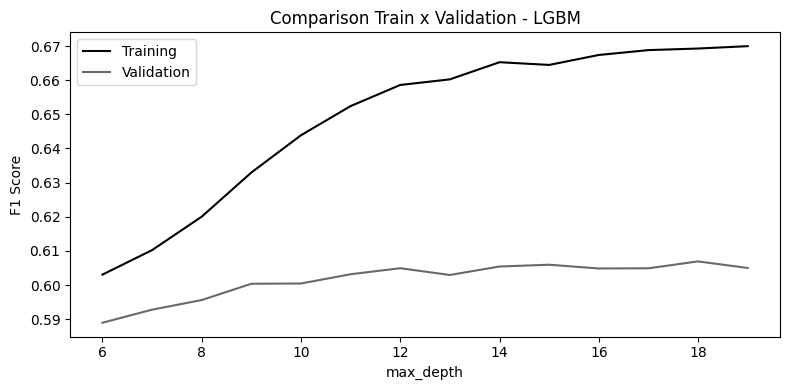

In [249]:
aux = lgbm_best_params
aux.pop('max_depth', None)

param_range = np.arange(6, 20, 1)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, max_depth = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("max_depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

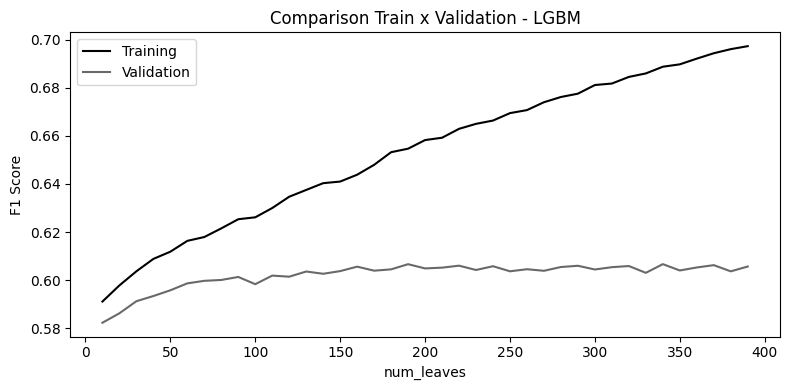

In [250]:
aux = lgbm_best_params
aux.pop('num_leaves', None)

param_range = np.arange(10, 400, 10)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, num_leaves = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("num_leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

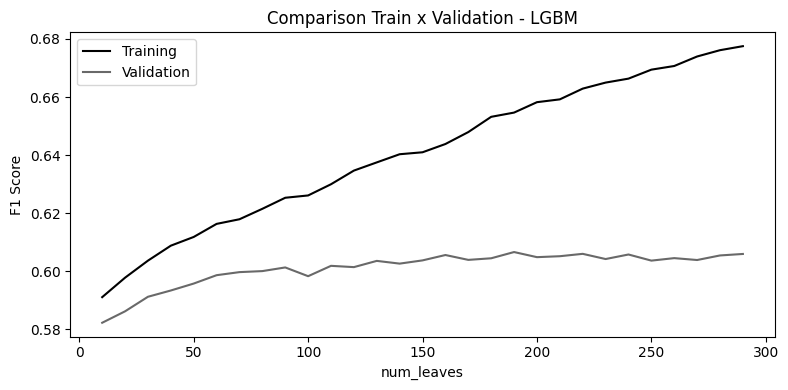

In [251]:
aux = lgbm_best_params
aux.pop('num_leaves', None)

param_range = np.arange(10, 300, 10)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, num_leaves = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("num_leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

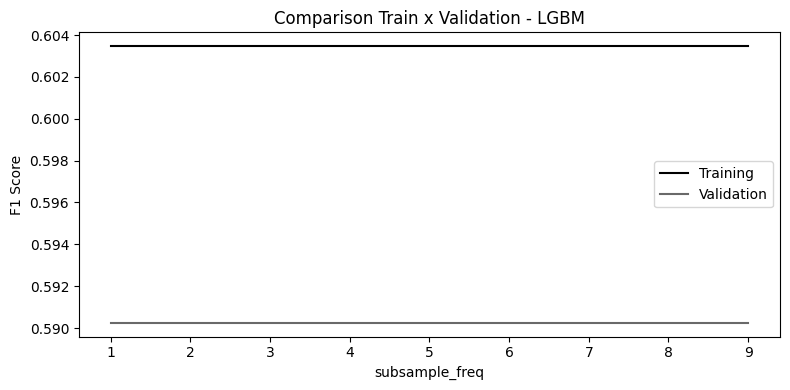

In [252]:
aux = lgbm_best_params
aux.pop('subsample_freq', None)

param_range = np.arange(1, 10, 1)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, subsample_freq = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("subsample_freq")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

In [265]:
 lgbm_best_params_revised = {'objective': 'binary', 
                             'boosting_type': 'gbdt', 
                             'num_leaves': 220, 
                             'max_depth': 13, 
                             'learning_rate': 0.071, 
                             'reg_alpha': 0.0022, 
                             'reg_lambda': 0.2497, 
                             'subsample_freq': 2, 
                             'min_child_samples': 1, 
                             'scale_pos_weight': 2.631}

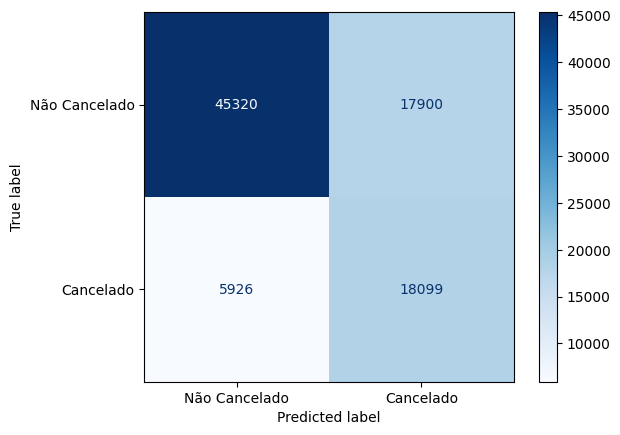

Score: 
               precision    recall  f1-score   support

           0       0.88      0.72      0.79     63220
           1       0.50      0.75      0.60     24025

    accuracy                           0.73     87245
   macro avg       0.69      0.74      0.70     87245
weighted avg       0.78      0.73      0.74     87245



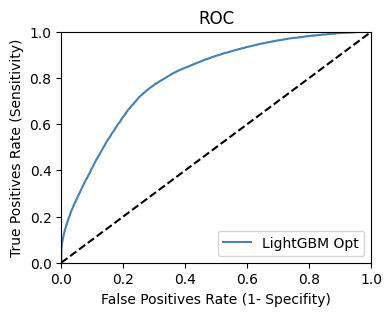

,value,std
fit_time,0.403979,0.019803
score_time,0.041621,0.002565
test_accuracy,0.726907,0.001002
train_accuracy,0.761319,0.001538
test_precision,0.502760,0.001215
train_precision,0.543852,0.001962
test_recall,0.753340,0.008528
train_recall,0.826358,0.002942
test_f1,0.603040,0.003270
train_f1,0.655979,0.001820


In [266]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params_revised)
y_prob_lgbm_tuned, y_pred_lgbm_tuned = CVS(model_lgbm_tuned,X,y,'LightGBM Opt')

In [267]:
results = data.copy()
results['lgbm_prob'] = y_prob_lgbm_tuned
results['lgbm_pred'] = y_pred_lgbm_tuned
results

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes,lgbm_prob,lgbm_pred
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2,0,0,Portugal,Native,0.074528,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2,0,0,Portugal,Native,0.616727,1.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1,0,1,United Kingdom,Europe,0.101276,0.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1,0,1,United Kingdom,Europe,0.372945,0.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,1,Check-Out,2015-07-03,2,0,2,United Kingdom,Europe,0.258867,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87240,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,Check-Out,2017-09-06,2,0,7,Belgium,Europe,0.368863,0.0
87241,City Hotel,0,102,2017,August,35,31,2,5,3,...,2,Check-Out,2017-09-07,3,0,7,France,Europe,0.754097,1.0
87242,City Hotel,0,34,2017,August,35,31,2,5,2,...,4,Check-Out,2017-09-07,2,0,7,Germany,Europe,0.731156,1.0
87243,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,Check-Out,2017-09-07,2,0,7,United Kingdom,Europe,0.495580,0.0


In [268]:
path = "/home/alysson/projects/Hotel-Booking-Cancelations/models/lgbm/"
filename = "lgbm_" + str(datetime.now().strftime("%d-%m-%y")) + str(".pkl")
filepath = str(path) + str(filename)

In [269]:
with open(filepath, 'wb') as file:
    pickle.dump(model_lgbm_tuned, file)